# NanoEvents tutorial

This is a rendered copy of [nanoevents.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/nanoevents.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fnanoevents.ipynb)

[NanoEvents](https://coffeateam.github.io/coffea/api/coffea.nanoaod.NanoEvents.html#coffea.nanoaod.NanoEvents) is a Coffea utility to wrap the CMS NanoAOD (or similar) flat nTuple structure into a single awkward array with appropriate object methods (such as Lorentz vector methods), cross references, and pre-built nested objects, all lazily accessed from the source ROOT TTree via uproot. NanoEvents is in a **experimental** stage at this point. Certain functionality may be fragile, and some functionality will not be available until it is ported to awkward-array version 1.

It can be instantiated as follows:

In [1]:
from coffea.nanoaod import NanoEvents

fname = "https://github.com/CoffeaTeam/coffea/raw/master/tests/samples/nano_dy.root"
events = NanoEvents.from_file(fname)

Consider looking at the class methods [from_file](https://coffeateam.github.io/coffea/api/coffea.nanoaod.NanoEvents.html#coffea.nanoaod.NanoEvents.from_file) and [from_arrays](https://coffeateam.github.io/coffea/api/coffea.nanoaod.NanoEvents.html#coffea.nanoaod.NanoEvents.from_arrays) to see the optional arguments.

The `events` object is an awkward array, which at its top level is a record array with one record for each "collection", where a collection is a grouping of column (TBranch) names, categorized as follows:

 * one branch exists named `name` and no branches start with `name_`, interpreted as a single flat array;
 * one branch exists named `name`, one named `n{name}`, and no branches start with `name_`, interpreted as a single jagged array;
 * no branch exists named `n{name}` and many branches start with `name_*`, interpreted as a flat table; or
 * one branch exists named `n{name}` and many branches start with `name_*`, interpreted as a jagged table.

Any ROOT TTree that follows such a naming convention should be readable as a NanoEvents array.

For example, in the file we opened, the branches:
```
Generator_binvar
Generator_scalePDF
Generator_weight
Generator_x1
Generator_x2
Generator_xpdf1
Generator_xpdf2
Generator_id1
Generator_id2
```
are grouped into one sub-record named `Generator` which can be accessed using either getitem or getattr syntax, i.e. `events["Generator"]` or `events.Generator`. e.g.

In [2]:
events.Generator.id1

<VirtualArray [1 -1 -1 ... -1 2 1] at 0x0001229cfd90>

In [3]:
# all column names can be listed with:
events.Generator.columns

['binvar', 'scalePDF', 'weight', 'x1', 'x2', 'xpdf1', 'xpdf2', 'id1', 'id2']

In [4]:
# In CMS NanoAOD, each TBranch has a help string, which is carried into the NanoEvents
# e.g. executing the following cell should produce a help pop-up "id of first parton"
events.Generator.id1?

Based on a collection's name, some collections acquire additional _methods_, which are extra features exposed by the code in the mixin classes of the [nanoaod.methods](https://coffeateam.github.io/coffea/modules/coffea.nanoaod.methods.html) module. For example, although `events.GenJet` has the columns:

In [5]:
events.GenJet.columns

['eta', 'mass', 'phi', 'pt', 'partonFlavour', 'hadronFlavour']

we can access additional attributes associated to each generated jet by virtue of the fact that they can be interpreted as Lorentz vectors:

In [6]:
events.GenJet.energy

<JaggedArray [[216.66086 669.76355 258.178] [34.46663 98.27996 1158.8408 38.086895 20.431288 29.717283] [305.5387 62.83623 74.116714 769.1337 11.190336] ... [553.1756 282.61493] [771.05457 451.83902 16.021221] [76.890686]] at 0x000122a3c890>

In [7]:
# or call LorentzVector methods
# e.g. to find distance between leading jet and all electrons in each event
events.Jet[:, 0].delta_r(events.Electron)

<JaggedArray [[] [3.1270556] [3.4542406 2.1806993] ... [0.085795395] [] []] at 0x00010694fc90>

The assignment of methods classes to collections is governed by [collection_methods](https://github.com/CoffeaTeam/coffea/blob/bfb1d3298fde9a6c2688c39b709c3b25076d437c/coffea/nanoaod/methods/__init__.py#L7) and can be overriden with new mappings in the NanoEvents constructor, if desired.
Additional methods provide convenience functions for interpreting some branches, e.g.

In [8]:
# unpacked Jet_jetId flags
print(events.Jet.isTight)

[[True True True True True] [True True True ... True True False] [True True True True True] ... [True] [True True False True True True] [True True]]


In [9]:
# unpacked GenPart_statusFlags
events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])

<JaggedArray [[True True False ... False False False] [True True False ... True True False] [False True False ... False False False] ... [True True False True True True] [True True False ... True True True] [True True False ... False False False]] at 0x0001229ef110>

CMS NanoAOD also contains pre-computed cross-references for some types of collections. For example, there is a TBranch `Electron_genPartIdx` which indexes the `GenPart` collection per event to give the matched generated particle, and `-1` if no match is found. NanoEvents transforms these indices into an awkward _indexed array_ pointing to the collection, so that one can directly access the matched particle using getattr syntax:

In [10]:
events.Electron.matched_gen.pdgId

<JaggedArray [[] [-11] [-11 11] ... [None] [] []] at 0x000106865bd0>

In [11]:
events.Muon.matched_jet.pt

<JaggedArray [[] [] [] ... [] [] []] at 0x0001229c1a10>

For generated particles, the parent index is similarly mapped:

In [12]:
events.GenPart.parent.pdgId

<JaggedArray [[None None 1 ... -15 111 111] [None None -1 ... None None 433] [None None -1 ... -421 111 111] ... [None None -1 23 23 23] [None None 2 ... -11 -11 11] [None None 1 ... 111 111 111]] at 0x0001215720d0>

In addition, using the parent index, a helper method computes the inverse mapping, namely, `children`. As such, one can find particle siblings with:

In [13]:
events.GenPart.parent.children.pdgId
# notice this is a doubly-jagged array

<JaggedArray [[None None [23 21] ... [-16 111 211 211 -211] [22 22] [22 22]] [None None [23] ... None None [431]] [None None [23 -1] ... [13 -14] [22] [22]] ... [None None [23] [23] [-13 13] [-13 13]] [None None [23] ... [-11 22] [-11 22] [11]] [None None [23 21] ... [22 22] [22 22] [22 22]]] at 0x000123c8f910>

Since often one wants to shortcut repeated particles in a decay sequence, a helper method `distinctParent` is also available. Here we use it to find the parent particle ID for all prompt electrons:

In [14]:
events.GenPart[
    (abs(events.GenPart.pdgId) == 11)
    & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
].distinctParent.pdgId

<JaggedArray [[] [23 23] [23 23] ... [] [23 23] []] at 0x00012408cf50>

Events can be filtered like any other awkward array using boolean fancy-indexing

In [15]:
mmevents = events[events.Muon.counts == 2]
zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
zmm.mass

array([94.60349, 87.58368, 87.96817, 90.37454, 89.10157, 31.58276],
      dtype=float32)

One can assign new variables to the arrays, with some caveats:

 * Assignment must use setitem (`x["name"] = value`)
 * Assignment is only allowed on the initial NanoEvents object (before any cuts)
 
(The latter limitation will go away with the migration to awkward1.)

In [16]:
events.Electron["pt2"] = events.Electron.pt ** 2
events.Electron.pt2

<JaggedArray [[] [873.79083] [3608.228 2673.4111] ... [58.934647] [] []] at 0x0001241ec990>

## Using NanoEvents with a processor

NanoEvents can also be used inside a coffea [processor](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC), as shown in this simple Z peak sketch below. The key change from the usual `run_uproot_job` syntax is to pass `"nano": True` as an executor argument. The dataset name is included in the `events` object under the `metadata` attribute.

In [17]:
from coffea import processor, hist

class MyZPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "Z mass", 60, 60, 120),
        )
    
    @property
    def accumulator(self):
        return self._histo
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        mmevents = events[events.Muon.counts == 2]
        zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
        out.fill(
            dataset=events.metadata["dataset"],
            mass=zmm.mass.flatten(),
        )
        return out
    
    def postprocess(self, accumulator):
        return accumulator

In [18]:
samples = {
    "DrellYan": [
        "https://github.com/CoffeaTeam/coffea/raw/master/tests/samples/nano_dy.root",
    ]
}

result = processor.run_uproot_job(
    samples,
    "Events",
    MyZPeak(),
    processor.iterative_executor,
    {"nano": True},
)

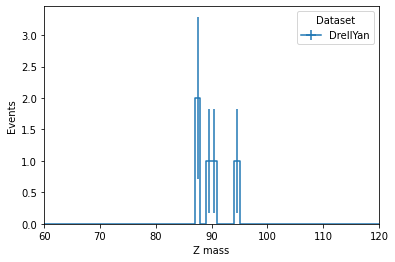

In [19]:
%matplotlib inline

hist.plot1d(result)